In [70]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from __future__ import division
import csv
import math
import powerlaw
from numpy import genfromtxt
import random
import pandas as pd

## The list of ESMs

In [71]:
ls LOCA2/*.csv

LOCA2/ACCESS-ESM1-5_hot_days_daily.csv  LOCA2/IPSL-CM6A-LR_hot_days_daily.csv
LOCA2/CanESM5_hot_days_daily.csv        LOCA2/MIROC6_hot_days_daily.csv
LOCA2/GFDL-ESM4_hot_days_daily.csv      LOCA2/MPI-ESM1-2-HR_hot_days_daily.csv
LOCA2/hot_days_per_year.csv             LOCA2/NorESM2-LM_hot_days_daily.csv
LOCA2/INM-CM5-0_hot_days_daily.csv


In [72]:
list_ESMs = ["ACCESS-ESM1-5", "CanESM5", "GFDL-ESM4", "INM-CM5-0",
             "IPSL-CM6A-LR", "MIROC6", "MPI-ESM1-2-HR", "NorESM2-LM"
            ]
color_list = ["coral", "slateblue", "chartreuse", "goldenrod", "teal", "crimson" ,"orchid", "sienna"]

## Change filename of other mode of travel

In [73]:
railonly_file_path = 'railonly.csv'

In [74]:
path_files_hot_days = {}
for esm in list_ESMs:
    path_files_hot_days[esm] = f"LOCA2/{esm}_hot_days_daily.csv"

In [75]:
dict_rm_nodes_sorted = {}
for esm in list_ESMs:
    df_heatwave = pd.read_csv(path_files_hot_days[esm])
    df_heatwave_select = df_heatwave[["dms_orig_string","hot_days_change"]]
    df_heatwave_select_sorted = df_heatwave_select.sort_values(by='hot_days_change', ascending=False)
    df_heatwave_select_sorted = df_heatwave_select_sorted.reset_index(drop=True)
    remove_nodes_sorted= list(df_heatwave_select_sorted["dms_orig_string"])
    dict_rm_nodes_sorted[esm] = remove_nodes_sorted

## Heatwave scenario can be changed as well

In [76]:
# 22, 41, 1 # tested till 50
random.seed(1)

In [77]:
# Load the filtered edges CSV file
edges_file_path = f'{railonly_file_path}'
edges = pd.read_csv(edges_file_path)

# Construct the graph using NetworkX
G = nx.Graph()
edges_array = edges[['dms_orig_string', 'dms_dest_string', 'distance_miles']].values
G.add_weighted_edges_from(edges_array)


#removed = None
# Degree robustness function
def degree_robust_remove(G):
    G = G.copy()
    Gc_d = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_d.append(len(gc))
        target = max(node_deg, key=lambda x: x[1])[0]
        G.remove_node(target)
        removed.append(target)
    return Gc_d, removed,G

# Random removal robustness function
def degree_robust_rand(G):
    G = G.copy()
    Gc_dr = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_dr.append(len(gc))
        # Random removal
        target = random.choice(list(G.nodes()))
        G.remove_node(target)
        removed.append(target)
    return Gc_dr, removed, G


# Random removal robustness function
def degree_hot_days(G, remove_nodes_sorted):
    G_test = G.copy()
    Gc_d_hw = []
    removed_hw = []
    gc = max(nx.connected_components(G_test), key=len)
    Gc_d_hw.append(len(gc))
    for node_hw in remove_nodes_sorted:
        try:
            G_test.remove_node(node_hw)
            removed_hw.append(node_hw)
            gc = max(nx.connected_components(G_test), key=len)
            Gc_d_hw.append(len(gc))
        except:
            pass
    return Gc_d_hw, removed_hw, G_test



Degree robustness (size of largest connected component after each removal): [84, 83, 82, 81, 80, 79, 78, 76, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 49, 48, 47, 44, 43, 38, 32, 26, 19, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Nodes removed in order: ['Houston TX', 'Iowa', 'Chicago IL-IN-WI (IL Part)', 'Los Angeles CA', 'Baton Rouge LA', 'New Orleans LA-MS (LA Part)', 'Wyoming', 'Atlanta GA', 'Detroit MI', 'Fort Wayne IN', 'Cleveland OH', 'Minneapolis-St. Paul MN-WI (MN Part)', 'Beaumont TX', 'San Francisco CA', 'Philadelphia PA-NJ-DE-MD (PA Part)', 'Portland OR-WA (OR Part)', 'Tampa FL', 'Philadelphia PA-NJ-DE-MD (NJ Part)', 'Indianapolis IN', 'Baltimore MD', 'Salt Lake City UT', 'Chicago IL-IN-WI (IN Part)', 'Columbus OH', 'Birmingham AL', 'New York NY-NJ-CT-PA (NY Part)', 'Charleston SC', 'Memphis TN-MS-AR (TN Part)', 'New York NY-NJ-CT-PA (

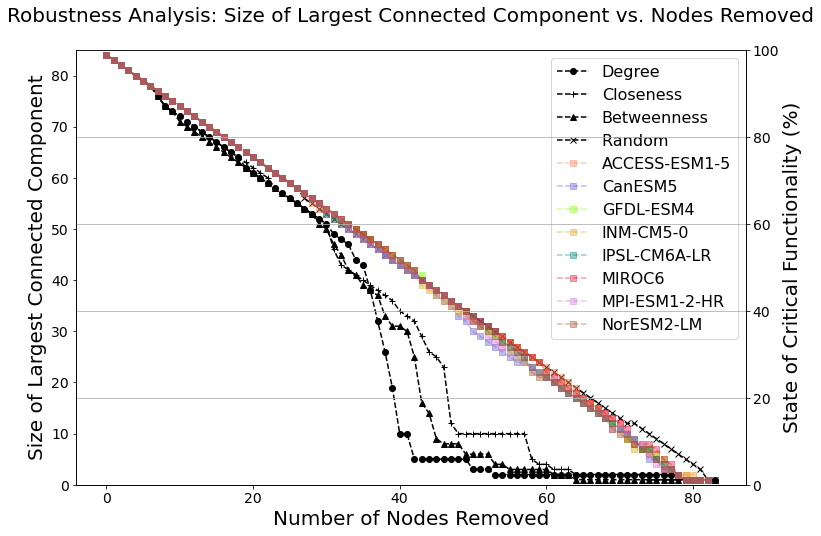

In [78]:
# Execute degree robustness analysis
Gc_d, removed_degree, G_updated_degree = degree_robust_remove(G)
print("Degree robustness (size of largest connected component after each removal):", Gc_d)
print("Nodes removed in order:", removed_degree)

# Execute random robustness analysis
Gc_dr,removed_random,G_updated_random = degree_robust_rand(G)
print("Random removal robustness (size of largest connected component after each removal):", Gc_dr)

#Closeness
closeness_c = nx.closeness_centrality(G)
temp = sorted(closeness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_closeness = [i[0] for i in temp]

# Betweenness Centrality
betweenness_c = nx.betweenness_centrality(G)
temp = sorted(betweenness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_betweenness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_close,removed_close, G_updated_close = degree_hot_days(G,sorted_nodes_by_closeness)

# Execute closeness robustness analysis
Gc_bw,removed_bw, G_updated_bw = degree_hot_days(G,sorted_nodes_by_betweenness)


# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(Gc_d, marker='o', linestyle='--', color='k', label='Degree')
ax.plot(Gc_close, marker='+', linestyle='--', color='k', label='Closeness')
ax.plot(Gc_bw, marker='^', linestyle='--', color='k', label='Betweenness')
ax.plot(Gc_dr, marker='x', linestyle='--', color='k', label='Random ')


for idx, esm in enumerate(list_ESMs):
    remove_nodes_sorted = dict_rm_nodes_sorted[esm]
    Gc_d_hw,removed_hw,G_updated_hw = degree_hot_days(G,remove_nodes_sorted)
    ax.plot(Gc_d_hw, marker='s', linestyle='--', color=color_list[idx], label=esm, alpha=0.4)
    
ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel('Size of Largest Connected Component', fontsize=20)
ax.set_ylim(0,85)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('State of Critical Functionality (%)', fontsize=20)

plt.title('Robustness Analysis: Size of Largest Connected Component vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Rail_DCBHR_LOCA.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Rail_DCBHR_LOCA.png',bbox_inches='tight')
plt.show()

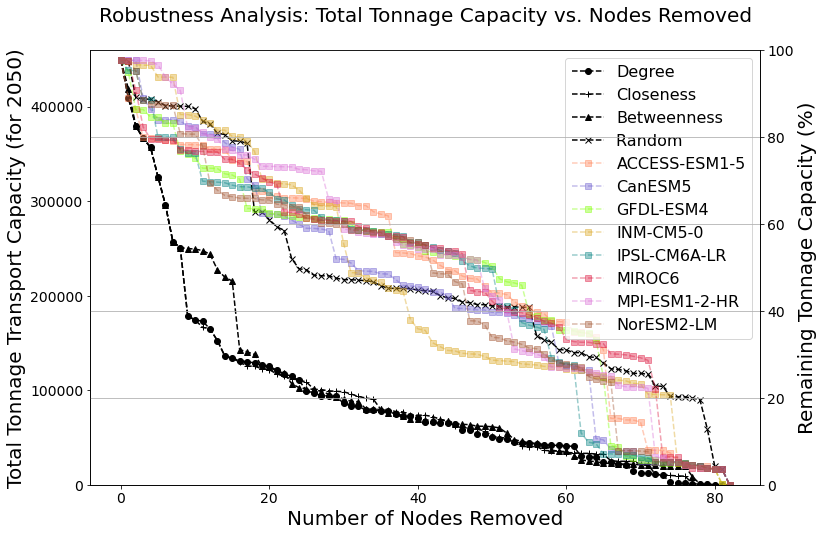

In [79]:
# Calclulation of tons
tonnage_year = '2050'
tons_data_rail = edges[['dms_orig_string', f'tons_{tonnage_year}']]
# Group by 'dms_orig_string' and sum the 'tons_2050' values
grouped_tons_rail = tons_data_rail.groupby('dms_orig_string')[f'tons_{tonnage_year}'].sum().reset_index()
total_tonnage_2050 = grouped_tons_rail[f'tons_{tonnage_year}'].sum()


def tonnage_loss (grouped_tons_rail, removed_degree):
    df = grouped_tons_rail.copy(deep=True)
    new_sum = df[f'tons_{tonnage_year}'].sum()
    cum_tonnage = [new_sum]
    for node_r in removed_degree:
        try:
            row = df[df['dms_orig_string'] == node_r].index[0]
            df = df.drop(row)
            # Calculate the new sum
            new_sum = df[f'tons_{tonnage_year}'].sum()
            cum_tonnage.append(new_sum)
        except:
            pass
    return cum_tonnage

cum_tonnage_degree = tonnage_loss (grouped_tons_rail, removed_degree)
cum_tonnage_random = tonnage_loss (grouped_tons_rail, removed_random)
cum_tonnage_bw = tonnage_loss (grouped_tons_rail, sorted_nodes_by_betweenness)
cum_tonnage_close = tonnage_loss (grouped_tons_rail, sorted_nodes_by_closeness)




# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(cum_tonnage_degree, marker='o', linestyle='--', color='k', label='Degree')
ax.plot(cum_tonnage_close, marker='+', linestyle='--', color='k', label='Closeness')
ax.plot(cum_tonnage_bw, marker='^', linestyle='--', color='k', label='Betweenness')
ax.plot(cum_tonnage_random, marker='x', linestyle='--', color='k', label='Random ')

for idx, esm in enumerate(list_ESMs):
    remove_nodes_sorted = dict_rm_nodes_sorted[esm]
    Gc_d_hw,removed_hw,G_updated_hw = degree_hot_days(G,remove_nodes_sorted)
    cum_tonnage_hw = tonnage_loss (grouped_tons_rail, removed_hw)
    ax.plot(cum_tonnage_hw, marker='s', linestyle='--', color=color_list[idx], label=esm, alpha=0.4)

ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel(f'Total Tonnage Transport Capacity (for {tonnage_year})', fontsize=20)
ax.set_ylim(0,460000)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('Remaining Tonnage Capacity (%)', fontsize=20)

plt.title('Robustness Analysis: Total Tonnage Capacity vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Tonnage_Rail_DCBHR_LOCA.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Tonnage_Rail_DCBHR_LOCA.png',bbox_inches='tight')
plt.show()


In [80]:
wateronly_file_path = 'wateronly.csv'

In [81]:
# 6, 20, 25,30 # tested till 50
random.seed(6)

Degree robustness (size of largest connected component after each removal): [42, 39, 36, 34, 28, 23, 13, 10, 8, 8, 7, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Nodes removed in order: ['New Orleans LA-MS (LA Part)', 'Houston TX', 'Baton Rouge LA', 'Corpus Christi TX', 'Beaumont TX', 'Pittsburgh PA-OH-WV (PA Part)', 'St. Louis MO-IL (IL Part)', 'Chicago IL-IN-WI (IL Part)', 'Memphis TN-MS-AR (TN Part)', 'Philadelphia PA-NJ-DE-MD (NJ Part)', 'New York NY-NJ-CT-PA (NY Part)', 'Cincinnati OH-KY-IN (KY Part)', 'Portland OR-WA (OR Part)', 'Los Angeles CA', 'Minneapolis-St. Paul MN-WI (MN Part)', 'Philadelphia PA-NJ-DE-MD (PA Part)', 'Louisville KY-IN (KY Part)', 'Savannah GA', 'Virginia Beach-Norfolk VA-NC (VA Part)', 'Albany NY  CFS Area', 'Chicago IL-IN-WI (IN Part)', 'Miami FL', 'Mobile AL', 'Nashville TN', 'San Francisco CA', 'New York NY-NJ-CT-PA (NJ Part)', 'Tampa FL', 'Tulsa OK', 'Philadelphia PA-NJ-DE-MD (DE Part)', 'S

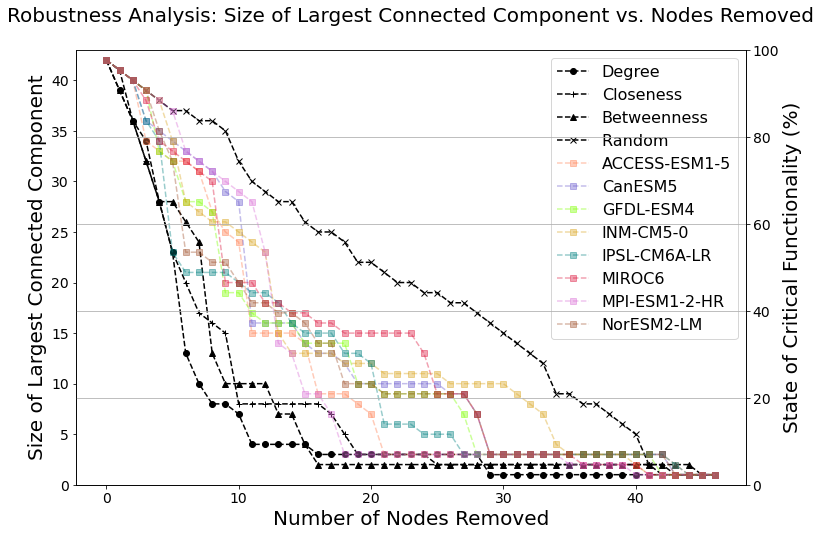

In [82]:
# Load the filtered edges CSV file
edges_file_path = f'{wateronly_file_path}'
edges = pd.read_csv(edges_file_path)

# Construct the graph using NetworkX
G = nx.Graph()
edges_array = edges[['dms_orig_string', 'dms_dest_string', 'distance_miles']].values
G.add_weighted_edges_from(edges_array)

# Degree robustness function
def degree_robust_remove(G):
    G = G.copy()
    Gc_d = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_d.append(len(gc))
        target = max(node_deg, key=lambda x: x[1])[0]
        G.remove_node(target)
        removed.append(target)
    return Gc_d, removed,G

# Random removal robustness function
def degree_robust_rand(G):
    G = G.copy()
    Gc_dr = []
    removed = []
    for i in range(len(G)):
        node_deg = list(G.degree())
        if not node_deg:
            break
        gc = max(nx.connected_components(G), key=len)
        Gc_dr.append(len(gc))
        # Random removal
        target = random.choice(list(G.nodes()))
        G.remove_node(target)
        removed.append(target)
    return Gc_dr, removed, G


# Random removal robustness function
def degree_hot_days(G, remove_nodes_sorted):
    G_test = G.copy()
    Gc_d_hw = []
    removed_hw = []
    gc = max(nx.connected_components(G_test), key=len)
    Gc_d_hw.append(len(gc))
    for node_hw in remove_nodes_sorted:
        try:
            G_test.remove_node(node_hw)
            removed_hw.append(node_hw)
            gc = max(nx.connected_components(G_test), key=len)
            Gc_d_hw.append(len(gc))
        except:
            pass
    return Gc_d_hw, removed_hw, G_test


# Execute degree robustness analysis
Gc_d, removed_degree, G_updated_degree = degree_robust_remove(G)
print("Degree robustness (size of largest connected component after each removal):", Gc_d)
print("Nodes removed in order:", removed_degree)

# Execute random robustness analysis
Gc_dr,removed_random,G_updated_random = degree_robust_rand(G)
print("Random removal robustness (size of largest connected component after each removal):", Gc_dr)

#Closeness
closeness_c = nx.closeness_centrality(G)
temp = sorted(closeness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_closeness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_close,removed_close, G_updated_close = degree_hot_days(G,sorted_nodes_by_closeness)

# Betweenness Centrality
betweenness_c = nx.betweenness_centrality(G)
temp = sorted(betweenness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_betweenness = [i[0] for i in temp]

# Execute closeness robustness analysis
Gc_bw,removed_bw, G_updated_bw = degree_hot_days(G,sorted_nodes_by_betweenness)

# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(Gc_d, marker='o', linestyle='--', color='k', label='Degree')
ax.plot(Gc_close, marker='+', linestyle='--', color='k', label='Closeness')
ax.plot(Gc_bw, marker='^', linestyle='--', color='k', label='Betweenness')
ax.plot(Gc_dr, marker='x', linestyle='--', color='k', label='Random ')

for idx, esm in enumerate(list_ESMs):
    remove_nodes_sorted = dict_rm_nodes_sorted[esm]
    Gc_d_hw,removed_hw,G_updated_hw = degree_hot_days(G,remove_nodes_sorted) 
    ax.plot(Gc_d_hw, marker='s', linestyle='--', color=color_list[idx], label=esm, alpha=0.4)

ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel('Size of Largest Connected Component', fontsize=20)
ax.set_ylim(0,43)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('State of Critical Functionality (%)', fontsize=20)

plt.title('Robustness Analysis: Size of Largest Connected Component vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Water_DCBHR_LOCA.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Water_DCBHR_LOCA.png',bbox_inches='tight')
plt.show()

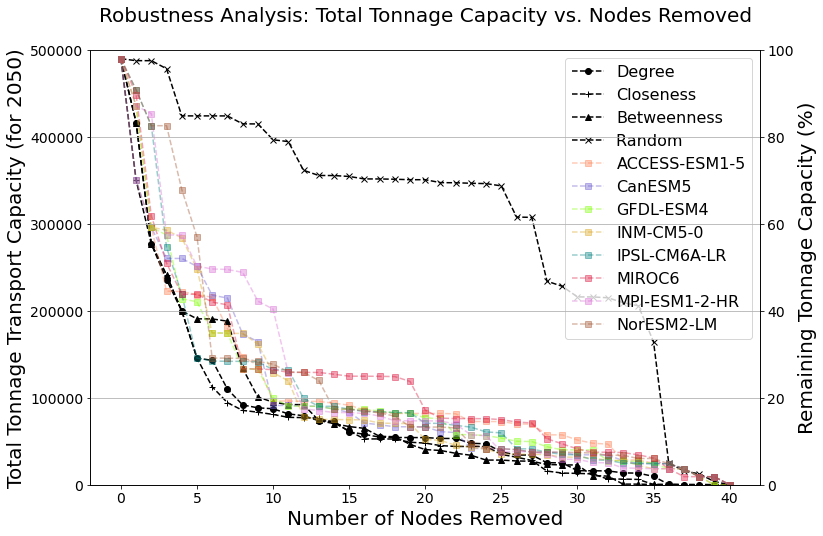

In [83]:
# Calclulation of tons
tonnage_year = '2050'
tons_data_rail = edges[['dms_orig_string', f'tons_{tonnage_year}']]
# Group by 'dms_orig_string' and sum the 'tons_2050' values
grouped_tons_rail = tons_data_rail.groupby('dms_orig_string')[f'tons_{tonnage_year}'].sum().reset_index()
total_tonnage_2050 = grouped_tons_rail[f'tons_{tonnage_year}'].sum()


def tonnage_loss (grouped_tons_rail, removed_degree):
    df = grouped_tons_rail.copy(deep=True)
    new_sum = df[f'tons_{tonnage_year}'].sum()
    cum_tonnage = [new_sum]
    for node_r in removed_degree:
        try:
            row = df[df['dms_orig_string'] == node_r].index[0]
            df = df.drop(row)
            # Calculate the new sum
            new_sum = df[f'tons_{tonnage_year}'].sum()
            cum_tonnage.append(new_sum)
        except:
            pass
    return cum_tonnage

cum_tonnage_degree = tonnage_loss (grouped_tons_rail, removed_degree)
cum_tonnage_random = tonnage_loss (grouped_tons_rail, removed_random)
cum_tonnage_hw = tonnage_loss (grouped_tons_rail, removed_hw)
cum_tonnage_bw = tonnage_loss (grouped_tons_rail, sorted_nodes_by_betweenness)
cum_tonnage_close = tonnage_loss (grouped_tons_rail, sorted_nodes_by_closeness)


# Combined plot : plt.subplots()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(cum_tonnage_degree, marker='o', linestyle='--', color='k', label='Degree')
ax.plot(cum_tonnage_close, marker='+', linestyle='--', color='k', label='Closeness')
ax.plot(cum_tonnage_bw, marker='^', linestyle='--', color='k', label='Betweenness')
ax.plot(cum_tonnage_random, marker='x', linestyle='--', color='k', label='Random ')

for idx, esm in enumerate(list_ESMs):
    remove_nodes_sorted = dict_rm_nodes_sorted[esm]
    Gc_d_hw,removed_hw,G_updated_hw = degree_hot_days(G,remove_nodes_sorted)
    cum_tonnage_hw = tonnage_loss (grouped_tons_rail, removed_hw)
    ax.plot(cum_tonnage_hw, marker='s', linestyle='--', color=color_list[idx], label=esm, alpha=0.4)


ax.set_xlabel('Number of Nodes Removed', fontsize=20)
ax.set_ylabel(f'Total Tonnage Transport Capacity (for {tonnage_year})', fontsize=20)
ax.set_ylim(0,500000)
# Create a secondary y-axis
ax2 = ax.twinx()
#y_ticks = ax.get_yticks()
#yy_ticks = [f"{a} %" for a in np.asarray(y_ticks *100/np.max(Gc_d), int)]
#yy_ticks = np.asarray(y_ticks *100/np.max(Gc_d), int)
#ax2.set_yticks(yy_ticks)
ax2.set_yticks(np.asarray(ax2.get_yticks() *100))
ax2.set_ylabel('Remaining Tonnage Capacity (%)', fontsize=20)

plt.title('Robustness Analysis: Total Tonnage Capacity vs. Nodes Removed\n', fontsize=20)
ax.legend(fontsize=16)
# Increase the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig( f'plots/Failure_Tonnage_Water_DCBHR_LOCA.pdf',bbox_inches='tight')
fig.savefig( f'plots/Failure_Tonnage_Water_DCBHR_LOCA.png',bbox_inches='tight')
plt.show()


In [84]:
def recovery_nodes(G, G_updated, removed_degrees):
    G = G_updated.copy()
    nodes_to_add = removed_random.copy()
    re_updated_G = G.copy()
    re_G_list = [len(re_updated_G)]
    for node in nodes_to_add:
        re_updated_G.add_node(node)
        re_updated_G.add_edges_from(list(G.edges(node)))
        re_G_list.append(len(re_updated_G))
    return re_updated_G, re_G_list

# Execute Recovery of random robustness analysis
_,re_G_list_rand = recovery_nodes(G, G_updated_random, removed_random)

# Execute Recovery of degree robustness analysis
_,re_G_list_degree = recovery_nodes(G, G_updated_degree, removed_degree)

# Execute Recovery of hot days robustness analysis
_,re_G_list_hw = recovery_nodes(G, G_updated_hw, removed_hw)

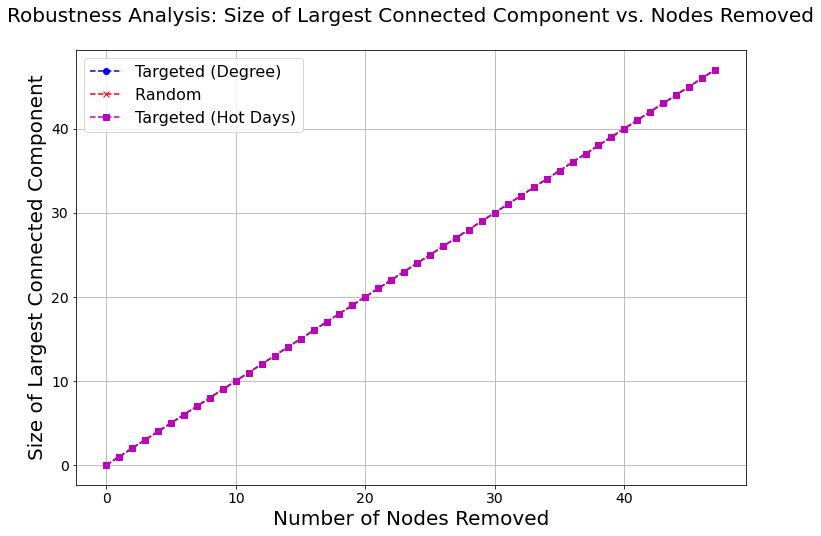

In [85]:
# Combined plot
plt.figure(figsize=(12, 8))
plt.plot(re_G_list_degree, marker='o', linestyle='--', color='b', label='Targeted (Degree)')
plt.plot(re_G_list_rand, marker='x', linestyle='--', color='r', label='Random ')
plt.plot(re_G_list_hw, marker='s', linestyle='--', color='m', label='Targeted (Hot Days)')
plt.xlabel('Number of Nodes Removed', fontsize=20)
plt.ylabel('Size of Largest Connected Component', fontsize=20)
plt.title('Robustness Analysis: Size of Largest Connected Component vs. Nodes Removed\n', fontsize=20)
plt.legend(fontsize=16)
# Increase the font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.show()
